Pattern and Anomaly Detection Lab Experiment 7

## Anomaly Detection using LSTM

Reeha Parkar

IBM AIML Batch - AIML1

BE Electronics 

**60001180046**


In [2]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [3]:
from google.colab import files
  
test = files.upload()

Saving GOOG.csv to GOOG.csv


In [4]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(test['GOOG.csv']))
print(df.head())
print(df.shape)

         Date       Open       High        Low      Close  Adj Close    Volume
0  2004-08-20  50.316402  54.336334  50.062355  53.952770  53.952770  22942874
1  2004-08-23  55.168217  56.528118  54.321388  54.495735  54.495735  18342897
2  2004-08-24  55.412300  55.591629  51.591621  52.239197  52.239197  15319808
3  2004-08-25  52.284027  53.798351  51.746044  52.802086  52.802086   9232276
4  2004-08-26  52.279045  53.773445  52.134586  53.753517  53.753517   7128620
(4116, 7)


In [5]:
# Extract "Date" and "Close" feature colums from the dataframe. 
df = df[['Date', 'Close']]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4116 non-null   object 
 1   Close   4116 non-null   float64
dtypes: float64(1), object(1)
memory usage: 64.4+ KB


In [7]:
df['Date'].min(), df['Date'].max() #extract from where data starts and ends

('2004-08-20', '2020-12-23')

In [8]:
#Closing price scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Apple Inc. Stock Price 2004-2020')
fig.show()

From the above graph it is observed that data is varying, hence scaling is done

In [9]:
#Separating into training and testing
train = df.loc[df['Date'] <= '2017-12-24']
test = df.loc[df['Date'] > '2017-12-24']
train.shape, test.shape

((3361, 2), (755, 2))

# Data Scaling

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))

train['Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test['Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



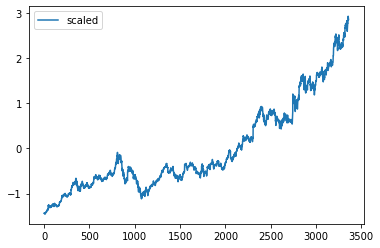

In [11]:
#plot training data
plt.plot(train['Close'], label = 'scaled')
plt.legend()
plt.show()

In [12]:
#Sequencing data with incremental changes
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (3331, 30, 1)
Testing input shape:  (725, 30, 1)


In [13]:

X_train[2]

array([[-1.43754117],
       [-1.43514693],
       [-1.43110003],
       [-1.43482912],
       [-1.44360096],
       [-1.44283819],
       [-1.44733004],
       [-1.44466035],
       [-1.44783856],
       [-1.44451203],
       [-1.4429865 ],
       [-1.44296531],
       [-1.43656654],
       [-1.43196873],
       [-1.42351471],
       [-1.42243413],
       [-1.41826009],
       [-1.41080191],
       [-1.40683975],
       [-1.41006033],
       [-1.40891617],
       [-1.4037463 ],
       [-1.40584392],
       [-1.40917043],
       [-1.39094874],
       [-1.3820074 ],
       [-1.38514323],
       [-1.3788292 ],
       [-1.37357459],
       [-1.36656136]])

In [14]:
np.random.seed(21)
tf.random.set_seed(21)
X_train.shape

(3331, 30, 1)

Build a model
We are building LSTM Autoencoder model. The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape. In this case, sequence_length is 30 and num_features is 1.

In [15]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))#to avoid overfitting
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

In [16]:
#Training the model
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
94/94 [==============================] - 12s 85ms/step - loss: 0.0805 - val_loss: 0.1805
Epoch 2/100
94/94 [==============================] - 7s 75ms/step - loss: 0.0240 - val_loss: 0.2068
Epoch 3/100
94/94 [==============================] - 7s 77ms/step - loss: 0.0162 - val_loss: 0.0581
Epoch 4/100
94/94 [==============================] - 7s 75ms/step - loss: 0.0284 - val_loss: 0.0454
Epoch 5/100
94/94 [==============================] - 7s 76ms/step - loss: 0.0198 - val_loss: 0.0848
Epoch 6/100
94/94 [==============================] - 7s 76ms/step - loss: 0.0148 - val_loss: 0.0380
Epoch 7/100
94/94 [==============================] - 7s 77ms/step - loss: 0.0147 - val_loss: 0.0353
Epoch 8/100
94/94 [==============================] - 7s 78ms/step - loss: 0.0197 - val_loss: 0.0807
Epoch 9/100
94/94 [==============================] - 8s 80ms/step - loss: 0.0231 - val_loss: 0.0961
Epoch 10/100
94/94 [==============================] - 7s 79ms/step - loss: 0.0237 - val_loss: 0.056

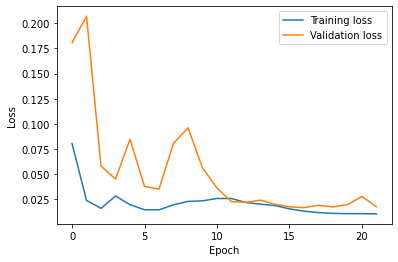

In [17]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();


Reconstruction error threshold: 0.4691748174975995


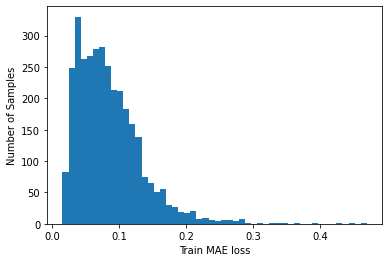

In [18]:
#Predicting value
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1) #mean average loss

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

23/23 [==============================] - 1s 22ms/step


Text(0, 0.5, 'Number of samples')

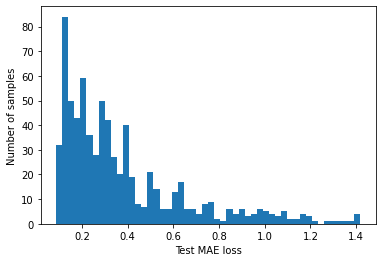

In [19]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [20]:

anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [21]:
anomaly_df

,Date,Close,loss,threshold,anomaly
3391,2018-02-08,2.600211,0.298949,0.469175,False
3392,2018-02-09,2.754443,0.390377,0.469175,False
3393,2018-02-12,2.814672,0.407962,0.469175,False
3394,2018-02-13,2.815352,0.400946,0.469175,False
3395,2018-02-14,2.890214,0.394943,0.469175,False
...,...,...,...,...,...
4111,2020-12-17,5.774928,1.383231,0.469175,True
4112,2020-12-18,5.703086,1.394162,0.469175,True
4113,2020-12-21,5.738646,1.405736,0.469175,True
4114,2020-12-22,5.671143,1.411651,0.469175,True


wherever anomaly value i.e loss is greater than anomaly df[threshold], those values are printed

In [22]:
anomaly_df.head

<bound method NDFrame.head of             Date     Close      loss  threshold  anomaly
3391  2018-02-08  2.600211  0.298949   0.469175    False
3392  2018-02-09  2.754443  0.390377   0.469175    False
3393  2018-02-12  2.814672  0.407962   0.469175    False
3394  2018-02-13  2.815352  0.400946   0.469175    False
3395  2018-02-14  2.890214  0.394943   0.469175    False
...          ...       ...       ...        ...      ...
4111  2020-12-17  5.774928  1.383231   0.469175     True
4112  2020-12-18  5.703086  1.394162   0.469175     True
4113  2020-12-21  5.738646  1.405736   0.469175     True
4114  2020-12-22  5.671143  1.411651   0.469175     True
4115  2020-12-23  5.708914  1.418404   0.469175     True

[725 rows x 5 columns]>

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

Points greater than 0.4691 can be considered as anomaly

In [24]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies

,Date,Close,loss,threshold,anomaly
3708,2019-05-15,3.292211,0.471546,0.469175,True
3721,2019-06-04,2.819393,0.510124,0.469175,True
3722,2019-06-05,2.773328,0.527452,0.469175,True
3723,2019-06-06,2.782345,0.538017,0.469175,True
3724,2019-06-07,2.874646,0.532241,0.469175,True
...,...,...,...,...,...
4111,2020-12-17,5.774928,1.383231,0.469175,True
4112,2020-12-18,5.703086,1.394162,0.469175,True
4113,2020-12-21,5.738646,1.405736,0.469175,True
4114,2020-12-22,5.671143,1.411651,0.469175,True


In [25]:
anomalies.shape

(185, 5)